In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch

from lampe.plots import corner
from tqdm import tqdm

from components.mcs import Lorenz63
from components.score import *

## Data

In [2]:
model = Lorenz63(dt=0.025, steps=1, wiener=0.0)

In [3]:
data = model.trajectory(model.prior((4096,)), steps=4096)[1024:]

MU = data.mean(dim=(0, 1))
SIGMA = data.std(dim=(0, 1))

def preprocess(x: Tensor) -> Tensor:
    return (x - MU) / SIGMA

def postprocess(x: Tensor) -> Tensor:
    return x * SIGMA + MU

data = preprocess(data)
data = data.unfold(0, 2, 1).reshape(-1, 3, 2)

## Training

In [4]:
score = MarkovChainScoreNet(3, hidden_features=[128] * 5, activation=nn.ELU)

In [5]:
sde_m = SubVariancePreservingSDE(score.marginal, shape=(3,))
sde_j = SubVariancePreservingSDE(score.joint, shape=(6,))

optimizer = torch.optim.AdamW(score.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    min_lr=1e-5,
    patience=32,
    threshold=1e-2,
    threshold_mode='abs',
)

with tqdm(range(256), unit='epoch', ncols=88) as tq:
    for epoch in tq:
        subset = torch.randint(len(data), (64, 1024))
        losses = []

        for x in data[subset].unbind():
            l = sde_m.loss(x[..., :-1].flatten(-2)) + sde_j.loss(x.flatten(-2))

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            losses.append(l.item())

        l = sum(losses) / len(losses)
        tq.set_postfix(loss=l, lr=optimizer.param_groups[0]['lr'])
        scheduler.step(l)

100%|██████████████████████| 256/256 [04:17<00:00,  1.01s/epoch, loss=0.436, lr=3.13e-5]


## Evaluation

In [6]:
x = postprocess(sde_m.sample((2**14,), steps=16))
y = model.trajectory(model.prior((2**14,)), steps=1024, last=True)

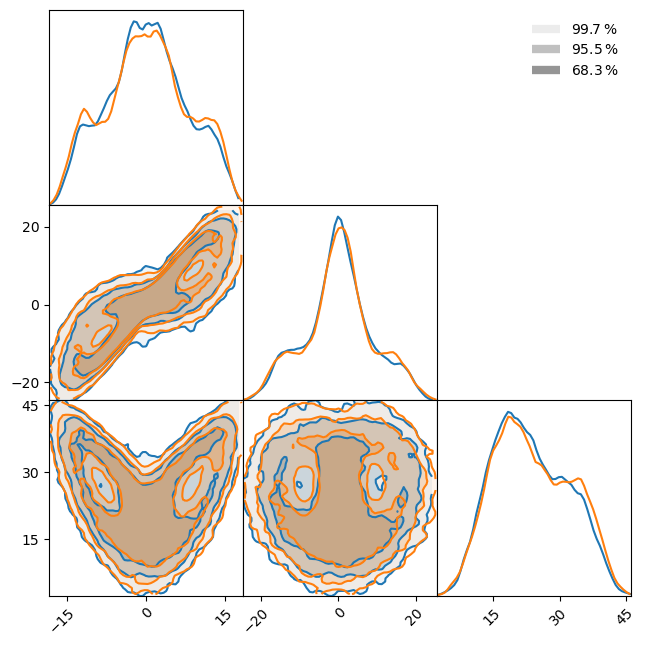

In [7]:
fig = corner(x, smooth=1)
fig = corner(y, smooth=1, figure=fig)

In [8]:
x = postprocess(sde_j.sample((256,), steps=16).reshape(-1, 3, 2).movedim(-1, 0))
y = model.transition(x[0])

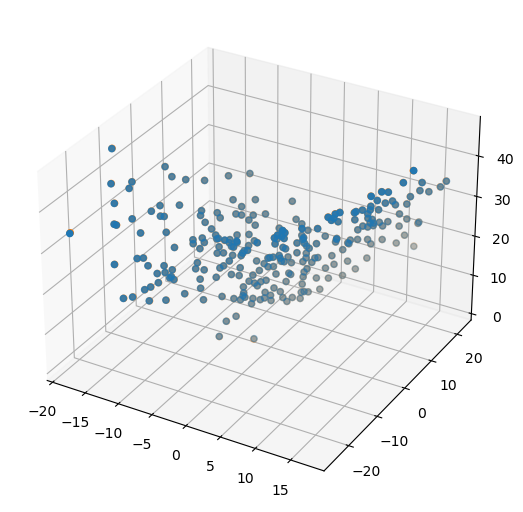

In [9]:
fig = plt.figure(figsize=(6.4, 6.4))

ax = plt.axes(projection='3d')
ax.scatter(x[1, : , 0], x[1, :, 1], x[1, :, 2])
ax.scatter(y[:, 0], y[:, 1], y[:, 2])

plt.show()

In [10]:
sde = SubVariancePreservingSDE(score, shape=(65, 3))

x = postprocess(sde.sample((), steps=256, corrections=2))
y = model.trajectory(x[0], 64)
z = model.transition(x)

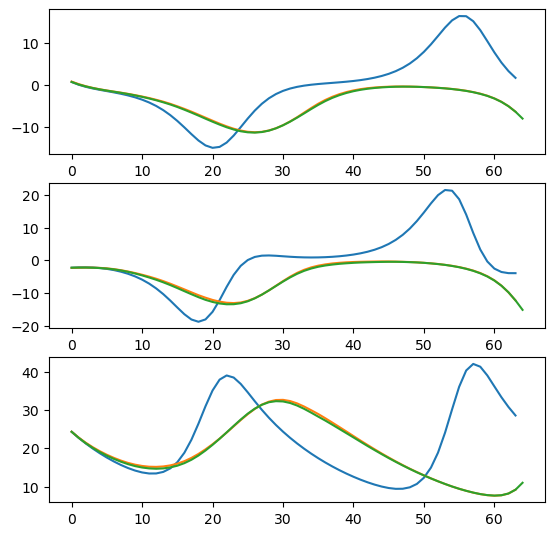

In [11]:
fig, axs = plt.subplots(3, figsize=(6.4, 6.4))

for i, ax in enumerate(axs.flat):
    ax.plot(y[1:, i])
    ax.plot(x[1:, i])
    ax.plot(z[:, i])

plt.show()

## Conditioning

In [12]:
mask = torch.zeros_like(y).bool()
mask[::8] = True

impute = ImputationScore(preprocess(y), mask, sigma=1e-4)
sde = SubVariancePreservingSDE(ComposedScore(score, impute), shape=y.shape)

x = postprocess(sde.sample((16,), steps=256, corrections=4))

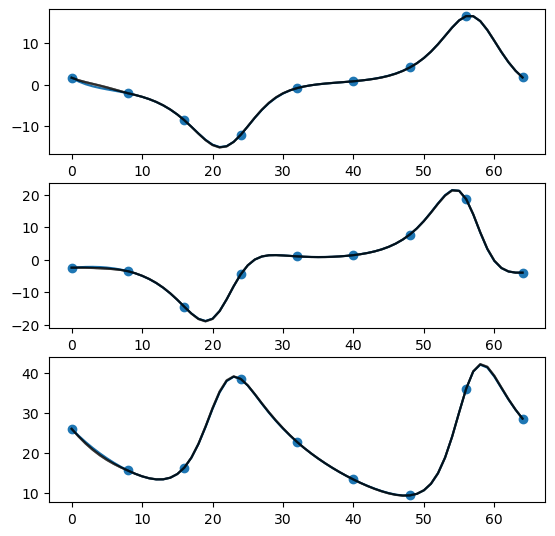

In [13]:
fig, axs = plt.subplots(3, figsize=(6.4, 6.4))

for i, ax in enumerate(axs.flat):
    ax.plot(y[:, i], '-o', markevery=8)

    for j in range(len(x)):
        ax.plot(x[j, :, i], color='black', alpha=0.1)

plt.show()